In [1]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime


## Group Assignment
### Team Number: 3
### Team Member Names: Julian Zhang, Jenna Johnston, Martin He
### Team Strategy Chosen: Market Beat

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.

**AI Usage:**  
OpenAI. (2024). ChatGPT (4o mini)[Large Language Model]. Retrieved from https://www.chatgpt.com  

Use of AI, with https://pandas.pydata.org/docs/index.html for:  
- Part 6: Writing code for running simulations to find optimal weights
- .idxmax() method used to efficiently get portfolio of highest simulated value  
- Part 7: Outputting the final porfolio weights
- lambda functions used with .apply() for more readable formating (i.e .apply(lambda x: f"{x:,.2f}"))  
- General Debugging


# 0. Outline
In order to beat the market, we form a portfolio with the follwing steps:
1. Filter tickers CSV to eliminate tickers that we aren't allowed to invest in, and convert the remaining legal ones to CAD
2. Calculate the Beta values of each ticker, then rank them
3. Calculate the Expected Percent Returns of each ticker, then rank them
4. Rank the stocks based on highest (normalized Beta times expected return), to reward stocks with high return and low market correlation
5. Calculate weights with a function that rewards stocks with high Beta and punishes low Beta, while remaining in [5%, 15%] of the portfolio
6. Iterate between using the top 12-24 stocks by plotting their historical returns for the past 2 weeks
7. Determine the optimal number of stocks and calculate the optimal weights. Output results to a CSV.


# 1. Filtering

We start by looping through the CSV file to remove tickers which do not meet the following criteria:
- Are not denominated in USD or CAD
- Have an average monthly volume of <100,000 shares from ``10-01-2023`` to ``09-30-2024``
- For the average monthly volume calculation, drop any month with <18 trading days

In [2]:
# Constants
start_date = '2023-10-01'
end_date = '2024-09-30'
csv = 'Tickers.csv' # CHANGE THIS BEFORE SUBMISSION (formerly Tickers_Example.csv)
starting_cash = 1000000

In [3]:
# Initializing
ticker_df = pd.read_csv(csv)
ticker_df.columns = ['Tickers']
ticker_df = ticker_df.drop_duplicates()
tick_list = ticker_df['Tickers'].tolist()

ticker_df.head()

,Tickers
0,AAPL
1,ABBV
2,LOW
3,AUST
4,HOOD


In [4]:
# Input: list of ticker strings (tickers)
# Output: list with non-USD or CAD stocks removed (filtered_list)
def filter_valid(tickers):
    filtered_list = []
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            currency = stock.fast_info['currency']
            if currency == 'USD' or currency == 'CAD':
                filtered_list.append(ticker)
            else: 
                print(f'{ticker} is not listed in USD or CAD, therefore has been removed')
        except (KeyError, AttributeError) as error:
                print(f'Stock {ticker} not found and was dropped. Error: {error}')
    return filtered_list

# Function application
filtered_list = filter_valid(tick_list)
print(f'Valid Tickers: {filtered_list}')

$INVALIDTIC: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


Stock INVALIDTIC not found and was dropped. Error: 'currency'


$HDFC.NS: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


Stock HDFC.NS not found and was dropped. Error: 'currency'


$CELG: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


Stock CELG not found and was dropped. Error: 'currency'
Valid Tickers: ['AAPL', 'ABBV', 'LOW', 'AUST', 'HOOD', 'AMZN', 'AXP', 'BAC', 'BK', 'SQ', 'VZ', 'CMCSA', 'SHOP', 'COST', 'CSCO', 'CVS', 'GM', 'GOOG', 'JPM', 'IBM', 'ORCL', 'OXY', 'DUOL', 'PEP', 'T.TO', 'SLB', 'SO', 'SPG', 'SHOP.TO', 'GC=F', 'RY.TO', 'TD.TO', 'AW.TO']


In [5]:
def filter_TO_duplicates(tickers):

    filtered_tickers = tickers.copy()

    # create a list of tickers that are listed .TO
    TO_listed_stocks = [ticker for ticker in tickers if '.TO' in ticker]

    for ticker in TO_listed_stocks:

        base_ticker = ticker.replace('.TO', '')
        if base_ticker in filtered_tickers:
            filtered_tickers.remove(ticker)
    
    return filtered_tickers

filtered_list = filter_TO_duplicates(filtered_list)
print(f'Valid Tickers after removing duplicates: {filtered_list}')


Valid Tickers after removing duplicates: ['AAPL', 'ABBV', 'LOW', 'AUST', 'HOOD', 'AMZN', 'AXP', 'BAC', 'BK', 'SQ', 'VZ', 'CMCSA', 'SHOP', 'COST', 'CSCO', 'CVS', 'GM', 'GOOG', 'JPM', 'IBM', 'ORCL', 'OXY', 'DUOL', 'PEP', 'T.TO', 'SLB', 'SO', 'SPG', 'GC=F', 'RY.TO', 'TD.TO', 'AW.TO']


In [6]:
# Input: list of USD/CAD ticker strings (tickers)
# Output: list with low-volume stocks removed (filtered_volume_list)
def filter_volume(tickers):
    filtered_volume_list = []
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=start_date, end=end_date)
            
            # If historical data is empty, drop it
            if hist.empty:
                print(f'{ticker} has no historical data in the specified period')
                continue
            
            # Group data by month
            monthly_data = hist.groupby(pd.Grouper(freq='ME'))
            valid_months = 0
            total_monthly_volume = 0

            for name, group in monthly_data:
                # If month has at least 18 trading days
                if len(group) >= 18:
                    valid_months += 1
                    monthly_volume = group['Volume'].mean()
                    total_monthly_volume += max(monthly_volume, 0)
            
            # If the stock mas more than 1 valid month
            if valid_months > 0:
                avg_monthly_volume = total_monthly_volume / valid_months
                # If the stock meets average monthly volume requirements, keep it
                if avg_monthly_volume >= 100000:
                    filtered_volume_list.append(ticker)
                # Otherwise drop it
                else:
                    print(f'{ticker} did not meet average monthly volume requirement')
            else:
                print(f'{ticker} did not have enough trading days')
        
        except (KeyError, IndexError, ValueError) as error:
            print(f'Error processing {ticker}: {error}')
    
    return filtered_volume_list

# Function application
filtered_volume_list = filter_volume (filtered_list)
print (f'Valid Tickers: {filtered_volume_list}')

AUST did not meet average monthly volume requirement
GC=F did not meet average monthly volume requirement


$AW.TO: possibly delisted; no price data found  (1d 2023-10-01 -> 2024-09-30) (Yahoo error = "Data doesn't exist for startDate = 1696132800, endDate = 1727668800")


AW.TO has no historical data in the specified period
Valid Tickers: ['AAPL', 'ABBV', 'LOW', 'HOOD', 'AMZN', 'AXP', 'BAC', 'BK', 'SQ', 'VZ', 'CMCSA', 'SHOP', 'COST', 'CSCO', 'CVS', 'GM', 'GOOG', 'JPM', 'IBM', 'ORCL', 'OXY', 'DUOL', 'PEP', 'T.TO', 'SLB', 'SO', 'SPG', 'RY.TO', 'TD.TO']


In [7]:
# Input: list of USD/CAD ticker strings (tickers)
# Output: list with USD stocks replaced by CAD prices (cad_df)
def convert_to_CAD(tickers):
    # Fetch exchange rate data
    conversion = yf.Ticker("USDCAD=X")
    usd_to_cad = conversion.history(period="1d")['Close'].iloc[-1]

    converted_data = {}

    for ticker in tickers:
        data = yf.Ticker(ticker)
        close_prices = data.history(start=start_date, end=end_date)['Close']

        if close_prices.empty:
            continue
        # If the stock is denominiated in USD, convert to CAD
        if data.fast_info['currency'] == 'USD':
            close_prices = close_prices * usd_to_cad
            
        converted_data[ticker] = close_prices

    cad_df = pd.DataFrame(converted_data)
    cad_df.index = cad_df.index.strftime('%Y-%m-%d')
    return cad_df

# Function application
prices_df = convert_to_CAD(filtered_volume_list)
prices_df.head()

,AAPL,ABBV,LOW,HOOD,AMZN,AXP,BAC,BK,SQ,VZ,...,ORCL,OXY,DUOL,PEP,T.TO,SLB,SO,SPG,RY.TO,TD.TO
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-02,241.869929,198.348159,281.149955,13.629005,181.337221,206.055581,36.383617,56.688412,60.497095,40.836008,...,147.126661,85.988821,232.449480,229.809750,20.027452,79.282572,83.877439,138.985873,110.245735,75.579323
2023-10-03,239.990682,197.251046,273.524692,13.348861,174.697800,199.948890,35.307098,55.677808,58.690170,41.118878,...,144.107192,86.209666,221.902060,227.812844,20.149286,80.199379,85.642991,137.312152,107.573975,74.864975
2023-10-04,241.744681,197.598918,272.745764,13.558970,177.891440,202.126914,35.347980,55.570006,58.690170,40.553143,...,147.636809,82.869486,228.499460,229.456556,20.795938,76.395345,86.432141,138.733498,108.572334,74.667595
2023-10-05,243.484766,197.277827,273.032743,13.629005,176.434690,203.594105,35.511496,56.176372,59.726700,40.913154,...,149.387805,82.013731,229.535980,217.488582,21.198923,75.806954,86.392007,138.866333,109.409035,75.533379
2023-10-06,247.076249,198.334801,272.677433,13.909150,179.236130,206.680750,35.525124,56.796219,61.393560,40.512624,...,151.607614,84.746616,230.054261,217.746686,21.133320,76.217455,86.900280,138.693636,109.247398,75.923470


# 2. Calculating Betas
Beta is a measure of how correlated the value of one security is with the market. We calculate the betas of each stock in our list to determine the relation of their performace with the performance of the market (in this case, the average of the S&P500 and TSX60). Our intention is to select stocks with low correlation to the market, so we can beat the market instead of meeting it. Beta is calculated with the following formulas, where $X$ and $Y$ represent two securities:
### Standard Deviation
$$
\begin{align*}
\sigma_X=\sqrt{\frac{\sum(x_i-\overline{X})^2}{N}}
\end{align*}
$$
### Variance
$$
\begin{align*}
\sigma^2_X=\frac{\sum(x_i-\overline{X})^2}{N}
\end{align*}
$$
### Covariance
$$
\begin{align*}
COV(X,Y)=\frac{\sum(x_i-\overline{X})\times(y_i-\overline{Y})}{N}
\end{align*}
$$
### Beta
$$
\begin{align*}
\beta=\frac{COV(x_i,r_M)}{\sigma^2(r_M)}
\end{align*}
$$
where:
- $COV$ = covariance
- $\sigma$ = variance
- $x_i$ = expected return on an asset $i$
- $r_M$ = average expected rate of return on the market


In [8]:
# Input: None
# Output: A dictionary (index_dict) with the prices of the TSX60 and S&P500
def create_index_df():
    # Fetch TSX 60 data
    tsx = yf.Ticker("^GSPTSE")
    tsx_data = tsx.history(start=start_date, end=end_date)
    
    # Fetch S&P 500 data
    sp500 = yf.Ticker("^GSPC")
    sp500_data = sp500.history(start=start_date, end=end_date)
    
    # Find trading days present in both datasets
    common_index = tsx_data.index.intersection(sp500_data.index)
    
    # Create a dictionary to match the structure expected by convert_to_CAD
    index_dict = {
        '^GSPTSE': tsx_data.loc[common_index, 'Close'],
        '^GSPC': sp500_data.loc[common_index, 'Close']
    }
    
    return index_dict

# Function application
index_df = convert_to_CAD(list(create_index_df().keys()))
index_df.head()

,^GSPTSE,^GSPC
Date,,
2023-10-02,19177.199219,6006.833833
2023-10-03,19020.900391,5924.275479
2023-10-04,19034.800781,5972.319901
2023-10-05,19137.800781,5964.531816
2023-10-06,19246.099609,6035.002121


In [9]:
# Input: Dataframe with 2 columns (index_df)
# Output: Dataframe with an additional column, representing an investment of $1m
def create_portfolio_column(index_prices_df):
    # Calculate the number of shares based on initial investment
    first_tsx_price = index_prices_df['^GSPTSE'].iloc[0]
    first_sp500_price = index_prices_df['^GSPC'].iloc[0]
    
    tsx_shares = 500000 / first_tsx_price
    sp500_shares = 500000 / first_sp500_price
    
    # Create portfolio column
    index_prices_df['Portfolio'] = (tsx_shares * index_prices_df['^GSPTSE']) + (sp500_shares * index_prices_df['^GSPC'])
    
    return index_prices_df

# Function application
index_prices_df = create_portfolio_column(index_df)
index_prices_df.head()

,^GSPTSE,^GSPC,Portfolio
Date,,,
2023-10-02,19177.199219,6006.833833,1.000000e+06
2023-10-03,19020.900391,5924.275479,9.890528e+05
2023-10-04,19034.800781,5972.319901,9.934144e+05
2023-10-05,19137.800781,5964.531816,9.954516e+05
2023-10-06,19246.099609,6035.002121,1.004141e+06


In [10]:
# Input: Two DataFrames (stock_df, index_df) 
# Output: The beta of thte two dataframes (Beta)
def calculate_beta(stock_df, index_df):

    # Ensure both DataFrames have a DatetimeIndex
    if not isinstance(stock_df.index, pd.DatetimeIndex):
        stock_df.index = pd.to_datetime(stock_df.index)
    if not isinstance(index_df.index, pd.DatetimeIndex):
        index_df.index = pd.to_datetime(index_df.index)
    
    prices = pd.DataFrame(stock_df)
    prices.columns = ['stock']
    prices['index'] = index_df

    daily_returns = prices.ffill().pct_change()
    daily_returns.drop(daily_returns.index[0], inplace=True)
    
    monthly_returns = prices.resample('ME').ffill().pct_change()
    monthly_returns.drop(monthly_returns.index[0], inplace=True)

    MarketVar=monthly_returns['index'].std() ** 2
    Beta=monthly_returns.cov() / MarketVar

    return Beta

# Calculating the beta of each stock with the market
stock_betas = {}
for ticker in prices_df.columns:
    # Use the portfolio column as the index
    beta = calculate_beta(prices_df[ticker], index_prices_df['Portfolio'])
    stock_betas[ticker] = beta.loc['stock', 'index']

# Sorting the betas and converting them to a DataFrame
beta_df = pd.DataFrame.from_dict(stock_betas, orient='index', columns=['Beta'])
beta_df = beta_df.sort_values('Beta', ascending=False)
beta_df

,Beta
SQ,6.069078
SHOP,3.866896
HOOD,3.192282
DUOL,2.970036
SPG,2.281740
BAC,1.866100
LOW,1.629858
JPM,1.571169
IBM,1.549615
CVS,1.368332


# 3. Calculating Percentage Returns
Now that we've calculated the correlation of each stock with the market, we don't want to blindly select stocks with a high beta in case their value decreases while the market increases. To ensure that our high-risk stocks also have high returns, we calculate the percent returns of each stock to find which ones have the largest returns.

### Expected returns
$$
\begin{align*}
E(X)=\overline{X}=\frac{\sum x_i}{N}
\end{align*}
$$
where 
- $x_i$ are individual returns of some security $X$
- $N$ is the total number of observations (time periods for us)

In [11]:
# Input: A ticker (ticker), optional parameters interval (interval), start date (start_date) and end date (end_date)
# Output: The percentage returns of that ticker (data)
def calculate_percentage_returns(ticker, interval = '1d', start_date = start_date, end_date = end_date):

    # check for valid interval otherwise default to 1day
    valid_intervals = ['1m','2m','5m','15m','30m','60m','90m','1h','1d','5d','1wk','1mo','3mo']
    if interval not in valid_intervals:
        interval = '1d'
        
    data = pd.DataFrame()

    # calculate percentage returns of Close value in time frame
    data['Return'] = yf.Ticker(ticker).history(start=start_date, end=end_date, interval='1d')['Close'].pct_change()

    # drop first value
    data.dropna(inplace=True)

    return data

In [12]:
# Input: A list of tickers (tickers)
# Output: A DataFrame with the tickers ranked by percent returns (sorted_returns_df)
def rank_stocks_by_returns(tickers, start_date=start_date, end_date=end_date):

    cumulative_returns = {}

    for ticker in tickers:
        try:
            # Calculate daily percentage returns
            returns_data = calculate_percentage_returns(ticker, start_date=start_date, end_date=end_date)

            # Calculate the cumulative return for the period
            cumulative_return = (1 + returns_data['Return']).prod() - 1  # Compound returns
            cumulative_returns[ticker] = cumulative_return

        except Exception as e:
            print(f"Error processing {ticker}: {e}")

    # Convert to DataFrame and sort by cumulative return
    returns_df = pd.DataFrame.from_dict(cumulative_returns, orient='index', columns=['Percent Return'])
    sorted_returns_df = returns_df.sort_values(by='Percent Return', ascending=False)
    
    return sorted_returns_df

# Function application
ranked_stocks = rank_stocks_by_returns(filtered_volume_list)
ranked_stocks

,Percent Return
HOOD,1.455293
AXP,0.837803
BK,0.760782
SPG,0.690206
DUOL,0.675384
IBM,0.630745
ORCL,0.602886
COST,0.595474
SQ,0.550590
BAC,0.516847


# 4. Filtering by Beta and ER
Now that we have our stocks ranked by both risk and reward, we must determine which ones we want for our portfolio. To do this, we first need to normalize our beta values so they're bounded by $[0,1]$ just like our percent returns. To do this, we'll use a sigmoid (or logistic) function, which is commonly used in statistics and machine learning as an activation function. The sigmoid function takes any real number value and scales it so it's between 0 and 1. The sigmoid function on some value $x$ is represented by $\sigma(x)$, and is defined as follows:
$$
\sigma(x)=\frac{1}{1+e^{-x}}
$$

Now, we want to reward stocks with both high risk and high reward. After taking the normalized beta values, we then define a constant that is the product of beta and percent returns. We then rank our list of tickers based on which ones have the highest value of
$$
\sigma(\beta (x_i, r_M))\cdot x_i
$$
where
- $x_i$ = average expected rate of return on a security $x$
- $r_M$ = average expected rate of return on the market

NOTE: there are some stocks with negative percent returns. We are fine with keeping them negative, as we want to beat the market and would thus never want to invest in stocks with negative returns. Those stocks would have a negative product, and fall to the bottom of our rankings.

In [13]:
# Input: A real number x
# Output: A normalized value of x on [0,1]
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Function application
beta_df['Sigmoid Beta'] = beta_df['Beta'].apply(sigmoid)
beta_df.head()

,Beta,Sigmoid Beta
SQ,6.069078,0.997692
SHOP,3.866896,0.979506
HOOD,3.192282,0.960543
DUOL,2.970036,0.951202
SPG,2.281740,0.907353


In [14]:
# Input: A DataFrame of betas (beta_df) and percent returns (ranked_stocks)
# Output: A combined dataframe with the stocks ranked by their weighted scores (weighted_df)
def create_weighted_df(beta_df, ranked_stocks, beta_weight=0.5, return_weight=0.5):

    # Merge beta_df with ranked_stocks
    combined_df = beta_df.join(ranked_stocks, how='inner')
    combined_df.dropna(subset=['Sigmoid Beta', 'Percent Return'], inplace=True)

    combined_df['Weighted Score'] = (
        combined_df['Sigmoid Beta'] * combined_df['Percent Return']
    )

    # Rank stocks based on their weighted score
    weighted_df = combined_df.sort_values(by='Weighted Score', ascending=False)

    return weighted_df

# Function application
weighted_df = create_weighted_df(beta_df, ranked_stocks)
weighted_df

,Beta,Sigmoid Beta,Percent Return,Weighted Score
HOOD,3.192282,0.960543,1.455293,1.397871
AXP,1.327651,0.790452,0.837803,0.662243
DUOL,2.970036,0.951202,0.675384,0.642427
SPG,2.281740,0.907353,0.690206,0.626261
BK,1.202783,0.769020,0.760782,0.585057
SQ,6.069078,0.997692,0.550590,0.549320
IBM,1.549615,0.824858,0.630745,0.520275
SHOP,3.866896,0.979506,0.466852,0.457284
BAC,1.866100,0.866006,0.516847,0.447593
ORCL,0.877191,0.706240,0.602886,0.425782


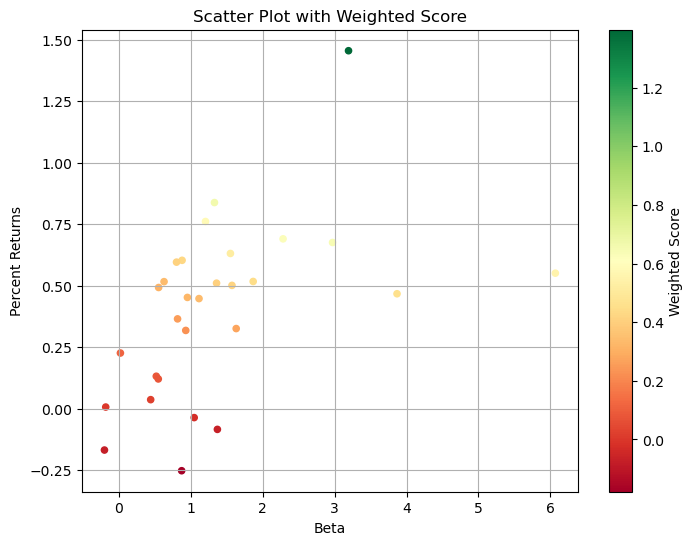

In [15]:
# scatter plot to show Beta, Percent Return, and Weighted Score
plt.figure(figsize=(8,6))
plt.scatter(weighted_df['Beta'], weighted_df['Percent Return'], c=weighted_df['Weighted Score'], cmap='RdYlGn', s=20)  
plt.colorbar(label='Weighted Score') 
plt.title('Scatter Plot with Weighted Score')
plt.xlabel('Beta')
plt.ylabel('Percent Returns')
plt.grid(True)
plt.show()

# 5. Calculating Weights
Given the top $n$ stocks, we calculate how much each one should be weighted in our portfolio while abiding by the bounds of
$$
[\frac{100}{2n}\%, 15\%]
$$
We calculate weights by summing our weighted scores, then taking the weighted average of each stock in proportion to the total. This ensures that stocks with high reward and high return are rewarded, while stocks with low risk and low return are penalized.

In [16]:
# Input: DataFrame sorted by Weighted Score (sorted_df) and number (n)
# Output: List of portfolio weights (weights)
def calculate_portfolio_weights(sorted_df, n):

    sorted_df = sorted_df.head(n)
    
    weights = []
    total = sorted_df["Weighted Score"].sum()
    remaining_portfolio = 1.00

    # calculate minimum allocation based on constraints
    min_allocation = 1 / (2 * n)

    for i, row in sorted_df.iterrows():
        score = row["Weighted Score"]

        allocation = score / total * remaining_portfolio

        # enforce minimum and maximum allocation limits
        if allocation < min_allocation:
            allocation = min_allocation
        elif allocation > 0.15:
            allocation = 0.15

        # add weight to the list
        weights.append(allocation)
        
        # update remaining portfolio and total
        remaining_portfolio -= allocation
        total -= score
    
    portfolio_weight = sum(weights)

    adjusted_weights = []

    if portfolio_weight > 1:
        excess = portfolio_weight - 1
        for weight in reversed(weights):
            if weight == min_allocation or excess == 0:
                adjusted_weights.append(weight)
                continue

            weight_above_min = weight - min_allocation
            if weight_above_min < excess:
                excess -= weight_above_min
                weight = min_allocation
            else:
                weight -= excess
                excess = 0
            adjusted_weights.append(weight)
            
            
        adjusted_weights = list(reversed(adjusted_weights))

    elif portfolio_weight < 1:
        deficit = 1 - portfolio_weight
        for weight in weights:
            if weight == 0.15 or deficit == 0:
                adjusted_weights.append(weight)
                continue

            weight_below_max = 0.15 - weight
            if weight_below_max < deficit:
                deficit -= weight_below_max
                weight = 0.15
            else:
                weight += deficit
                deficit = 0
            adjusted_weights.append(weight)
    else:
        adjusted_weights = weights


    return adjusted_weights




# Testing

for i in range(12, 25):
    weights = calculate_portfolio_weights(weighted_df, i)
    print(weights)
    print(sum(weights))

[0.15, 0.0980354561968586, 0.09510194072697103, 0.09270880591624138, 0.08660912247714571, 0.0813188038648125, 0.07701915111079424, 0.06769424718840077, 0.06625956846817335, 0.06303082635763695, 0.06140195557296761, 0.060820122119997835]
1.0
[0.15, 0.09156852359561751, 0.08882851818387029, 0.08659324709027982, 0.08089593074590476, 0.07595458928155717, 0.07193856416235239, 0.06322877978464769, 0.0618887399935187, 0.058872982637943806, 0.05735156070891538, 0.05680810804052567, 0.05607045577486673]
1.0
[0.15, 0.08681512143543936, 0.08421735210145852, 0.08209811588565837, 0.07669655221649478, 0.07201172011004114, 0.06820417036782575, 0.05994651851612422, 0.05867604136276372, 0.05581683460957561, 0.05437439102375958, 0.05385914945877574, 0.053159789367494624, 0.04412424354458855]
1.0
[0.15, 0.08253413519712212, 0.08006446583680009, 0.07804973239569607, 0.07291452808134007, 0.0684607122016099, 0.06484091855278726, 0.056990464126527786, 0.05578263614211048, 0.05306442124103888, 0.0516931067516

# 6. Running Simulations

To determine how many stocks we want in our portfolio ($n\in[12,24]$), we iterate through picking the top 12 to top 24 stocks, and project their portfolio values had we bought them two weeks ago (``2024-11-06`` to ``2024-11-20``). This is so we can get an accurate understanding of how these stocks move in a short time period, as the competition also lasts two weeks. We then select the portfolio with the highest historical return.

Limitations:
- We have $\$1,000,000$ CAD to spend
- There is a flat fee of $\min(3.95, 0.001\times\text{shares})$ for every stock we purchase
- We may pick n stocks, where $n\in[12,24]$
- Each stock must make up a minimum of $\frac{100}{2n}\%$ of our portfolio, and a maxmimum of $15\%$.

We will simulate $24-12+1=13$ different portfolios, graph their performance, and select the one with the highest return. Finally, we plot this optimal portfolio against the performance of the ``TSX60`` and ``S&P500`` portfolio to demonstrate that we beat the market.

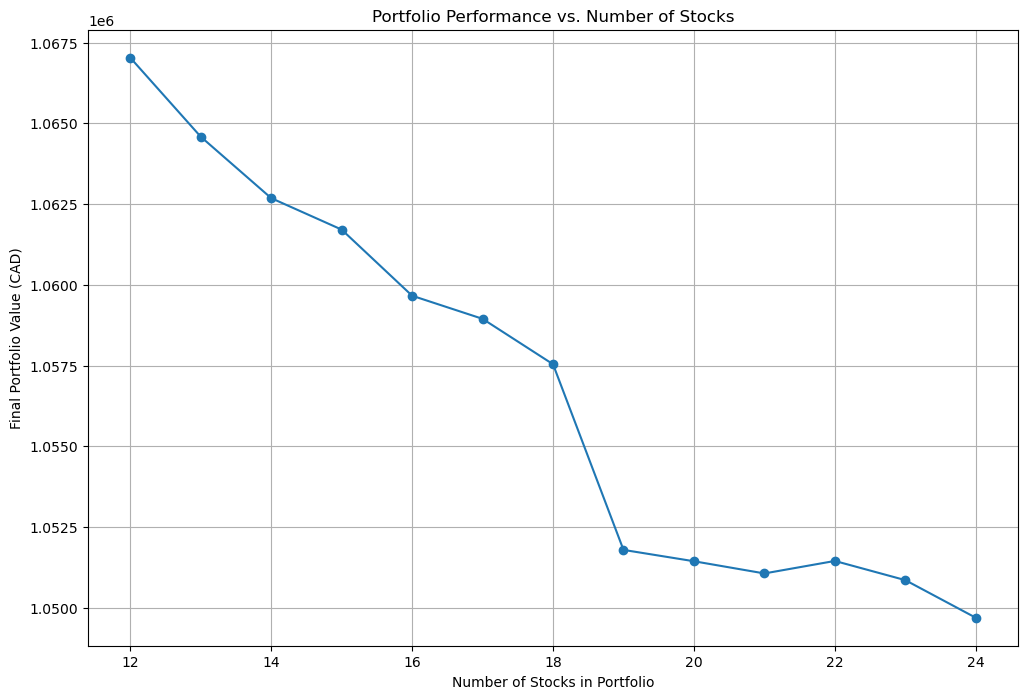

,Number of Stocks,Final Value
0,12,1.067029e+06
1,13,1.064584e+06
2,14,1.062682e+06
3,15,1.061708e+06
4,16,1.059661e+06
5,17,1.058946e+06
6,18,1.057540e+06
7,19,1.051793e+06
8,20,1.051442e+06
9,21,1.051064e+06


In [17]:
simulation_start_date = '2024-11-06'
simulation_end_date = '2024-11-20'

# Input: DataFrame with stocks sorted by their weights (weighted_df)
# Output: DataFrame displaying how well portfolios with the top 12-15 stocks perform (portfolio_df), nand
#         DataFrame with the weights of the top portfolio (best_portfolio)
def create_and_evaluate_portfolios(weighted_df, initial_budget, start_date, end_date):

    portfolios = []
    portfolio_results = []

    # iterate over different portfolio sizes 12 to 24
    for n in range(12, 25):
        portfolio_info = {
            "Number of Stocks": n,
            "Total Allocation": 0,
            "Total Fee": 0,
            "Remaining Budget": initial_budget,
            "Stocks Purchased": {}
        }
        
        # calculate portfolio weights for a portfolio of size n
        weights = calculate_portfolio_weights(weighted_df, n)
        
        # select the top n stocks based on the weighted scores
        stock_list = weighted_df.head(n).index.tolist()
        allocation_amounts = [weight * initial_budget for weight in weights]

        total_fee = 0
        total_allocation = 0
        remaining_budget = initial_budget
        
        # iterate over the selected stocks to "purchase" them and add to the portfolio
        for i in range(len(stock_list)):
            stock = stock_list[i]
            allocation = allocation_amounts[i]

            # calculate number of (fractional) shares to buy
            stock_data = yf.Ticker(stock).history(start=start_date, end=end_date, interval="1d")['Close']
            latest_price = stock_data.iloc[0]

            if pd.isna(latest_price):
                print(f"couldn't find price data for {stock}")
                continue  

            # calculate number of (fractional) shares to buy
            num_shares = allocation / latest_price
            fee = min(3.95, 0.001 * num_shares)

            total_cost = num_shares * latest_price + fee

            # update remaining budget and total fees
            remaining_budget -= total_cost
            total_fee += fee

            total_allocation += total_cost - fee  

            # add stock to portfolio df
            portfolio_info["Stocks Purchased"][stock] = {
                    "Shares": num_shares,
                    "Allocation": total_cost - fee,
                    "Price per Share": latest_price,
                    "Fee": fee
            }
        
        # the overall portfolio information
        portfolio_info["Total Allocation"] = total_allocation
        portfolio_info["Total Fee"] = total_fee
        portfolio_info["Remaining Budget"] = remaining_budget
        portfolios.append(portfolio_info)

        # calculate final portfolio value
        final_value = 0
        portfolio_stocks = portfolio_info["Stocks Purchased"]
        for stock, info in portfolio_stocks.items():
            stock_data = yf.Ticker(stock).history(start=start_date, end=end_date, interval="1d")['Close']
            end_price = stock_data.iloc[-1]

            if pd.isna(end_price):
                continue  
            final_value += info["Shares"] * end_price

        portfolio_results.append({"Number of Stocks": n, "Final Value": final_value})
        
    # Create a DataFrame for portfolio performance
    portfolio_df = pd.DataFrame(portfolio_results)

    best_portfolio_index = portfolio_df['Final Value'].idxmax()
    best_portfolio = portfolios[best_portfolio_index]

    return portfolio_df, best_portfolio

portfolio_df, best_portfolio = create_and_evaluate_portfolios(weighted_df, starting_cash, simulation_start_date, simulation_end_date)

plt.figure(figsize=(12, 8))
plt.plot(portfolio_df['Number of Stocks'], portfolio_df['Final Value'], marker='o')
plt.title('Portfolio Performance vs. Number of Stocks')
plt.xlabel('Number of Stocks in Portfolio')
plt.ylabel('Final Portfolio Value (CAD)')
plt.grid(True)
plt.show()

# Display the final results DataFrame
portfolio_df

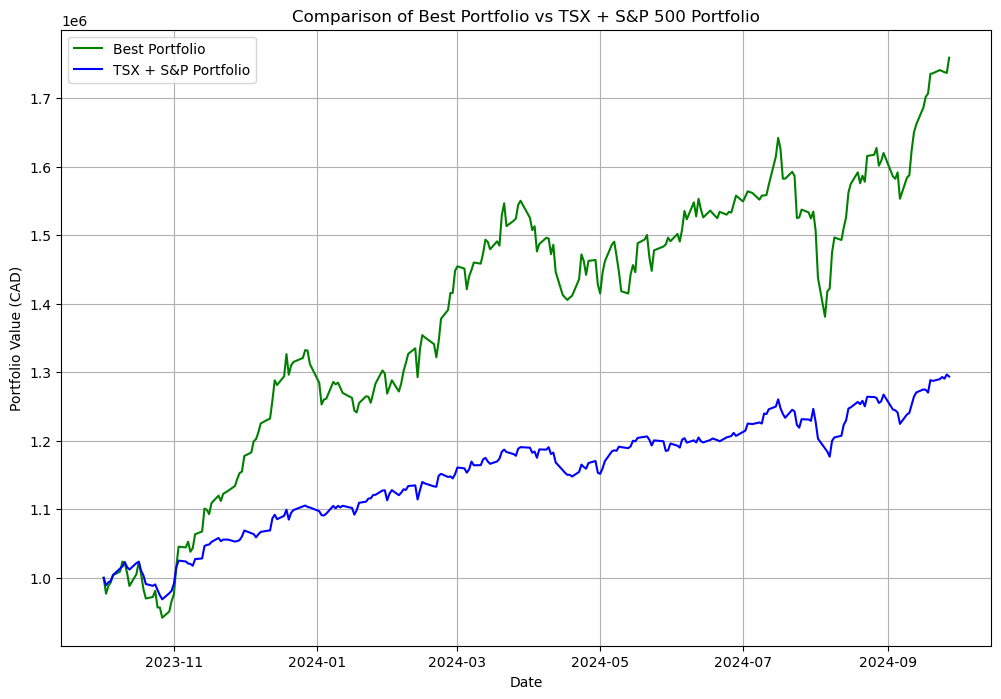

In [18]:
# Input: DataFrame with the best performing portfolio (best_portfolio)
# Output: A plot of the best portfolio against the TSX60 + S&P500

def plot_best_portfolio_vs_index(best_portfolio, start_date=start_date, end_date=end_date):

    portfolio_stocks = best_portfolio["Stocks Purchased"]
    portfolio_data= pd.DataFrame()

    for ticker in portfolio_stocks:
        stock_data = yf.Ticker(ticker).history(start=start_date, end=end_date, interval="1d")['Close']
        allocation = portfolio_stocks[ticker]["Allocation"]

        # recalculate shares using initial price
        num_shares = allocation / stock_data.iloc[0]

        portfolio_data[ticker] = num_shares * stock_data
    
    portfolio_data['Portfolio Value'] = portfolio_data.sum(axis=1)

    # create portfolio data for market indexes (TSX & S&P500)
    index_dict = create_index_df() 
    index_prices_df = create_portfolio_column(pd.DataFrame(index_dict))

    # Select data within the date range for the plot
    index_prices_df = index_prices_df.loc[start_date:end_date]

    # plot portfolio against market index
    plt.figure(figsize=(12, 8))
    plt.plot(portfolio_data.index, portfolio_data['Portfolio Value'], label='Best Portfolio', color='green')
    plt.plot(index_prices_df.index, index_prices_df['Portfolio'], label='TSX + S&P Portfolio', color='blue', linestyle='-')
    
    plt.title('Comparison of Best Portfolio vs TSX + S&P 500 Portfolio')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (CAD)')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_best_portfolio_vs_index(best_portfolio, start_date=start_date, end_date=end_date)

# 7. Outputting Data

We're almost done! To finish, we purchase our portfolio using the optmial weights. To ensure that our portfolio value ends up as $\$1,000,000$ and our weights sum to $100\%$, we scale our values accordingly. Finally, we output a DataFrame displaying the adjusted Ticker, Price, Currency, Value, Shares, and Weight of our optimal portfolio, and outputting the weights of our optimal portfolio to a CSV :)

In [19]:
final_start = '2024-11-22'
final_end = '2024-11-23'

In [20]:
# Input: The weighted DataFrame of our top stocks (weighted_df)
# Outputs: The adjusted Ticker, Price, Currency, Value, Shares, and Weight of our optimal portfolio (portfolio_final_df)
def create_portfolio_final(weighted_df, initial_budget=starting_cash, start_date=final_start, end_date=final_end):

    # calculate the number of stocks in our optimal portfolio
    optimal_portfolio_size = len(best_portfolio["Stocks Purchased"])

    stock_list = weighted_df.head(optimal_portfolio_size).index.tolist()  
    stock_weights = calculate_portfolio_weights(weighted_df, optimal_portfolio_size)

    # normalize weights so they sum to 100% (as a percentage)
    weight_sum = sum(stock_weights)
    normalized_weights = [weight / weight_sum * 100 for weight in stock_weights]

    portfolio_data = []

    for i in range(len(stock_list)):
        stock = stock_list[i]
        weight = normalized_weights[i]

        stock_data = yf.Ticker(stock).history(start=start_date, end=end_date, interval="1d")['Close']

        # fetch price on November 22, 2024
        latest_price = stock_data.iloc[-1]  
        
        # determine the currency (assuming CAD for Canadian stocks otherwise USD)
        stock_info = yf.Ticker(stock).info
        currency = stock_info.get('currency', 'USD')
        
        allocation = weight * initial_budget / 100 
        
        # calculate num_shares bought using price on November 22, 2024
        num_shares = allocation / latest_price 
        stock_value = num_shares * latest_price
        
        # append the relevant stock data to the portfolio list
        portfolio_data.append({
            "Ticker": stock,
            "Price": latest_price,
            "Currency": currency,
            "Shares": num_shares,
            "Value": stock_value,
            "Weight": weight
        })
    
    # creating the Portfolio_Final df
    portfolio_final_df = pd.DataFrame(portfolio_data)
    portfolio_final_df.index = range(1, len(portfolio_final_df) + 1)
    print(portfolio_final_df)
    
    # recalculate total value and total weight
    total_value = portfolio_final_df['Value'].sum()
    total_weight = portfolio_final_df['Weight'].sum()
    print(f"\nTotal Portfolio Value: {total_value:.2f} CAD")
    print(f"Total Weights: {total_weight:.2f}%")
    
    # rescale the portfolio to match the initial budget, necessary if price doesnt match exactly
    if total_value != initial_budget:
        scaling_factor = initial_budget / total_value
        portfolio_final_df['Value'] = portfolio_final_df['Value'] * scaling_factor
        portfolio_final_df['Shares'] = portfolio_final_df['Shares'] * scaling_factor
        portfolio_final_df['Weight'] = portfolio_final_df['Weight'] * scaling_factor
    
    # recalculating total value and total weight using updated values
    total_value = portfolio_final_df['Value'].sum()
    total_weight = portfolio_final_df['Weight'].sum()
    
    # rounding to 6 decimal places for weight
    portfolio_final_df['Weight'] = portfolio_final_df['Weight'].round(6)
    
    # formatting for better readability
    portfolio_final_df['Value'] = portfolio_final_df['Value'].apply(lambda x: f"{x:,.2f}")
    portfolio_final_df['Price'] = portfolio_final_df['Price'].apply(lambda x: f"{x:,.6f}")
    portfolio_final_df['Shares'] = portfolio_final_df['Shares'].apply(lambda x: f"{x:,.2f}")
    
    print("\nPortfolio after adjusting to initial budget:")
    print(portfolio_final_df)

    print(f"\nAdjusted Total Portfolio Value: {total_value:.2f} CAD")
    print(f"Adjusted Total Weights: {total_weight:.2f}%")

    # saving tickers and number of shares of each stock in a csv file
    stocks_final_df = portfolio_final_df[['Ticker', 'Shares']]
    stocks_final_df.to_csv('Stocks_Group_03.csv', index=False)  

    return portfolio_final_df, stocks_final_df


portfolio_final_df, stocks_final_df = create_portfolio_final(weighted_df, start_date=final_start, end_date=final_end)

   Ticker       Price Currency       Shares          Value     Weight
1    HOOD   36.650002      USD  4092.769270  150000.000000  15.000000
2     AXP  301.299988      USD   325.374909   98035.456197   9.803546
3    DUOL  351.970001      USD   270.198995   95101.940727   9.510194
4     SPG  181.139999      USD   511.807476   92708.805916   9.270881
5      BK   80.139999      USD  1080.722774   86609.122477   8.660912
6      SQ   92.260002      USD   881.409083   81318.803865   8.131880
7     IBM  222.970001      USD   345.423827   77019.151111   7.701915
8    SHOP  106.959999      USD   632.893117   67694.247188   6.769425
9     BAC   47.000000      USD  1409.778053   66259.568468   6.625957
10   ORCL  192.289993      USD   327.790465   63030.826358   6.303083
11    JPM  248.550003      USD   247.040655   61401.955573   6.140196
12   COST  964.010010      USD    63.090758   60820.122120   6.082012

Total Portfolio Value: 1000000.00 CAD
Total Weights: 100.00%

Portfolio after adjusting t

In [21]:
# displaying final stocks and shares
stocks_final_df

,Ticker,Shares
1,HOOD,"4,092.77"
2,AXP,325.37
3,DUOL,270.20
4,SPG,511.81
5,BK,"1,080.72"
6,SQ,881.41
7,IBM,345.42
8,SHOP,632.89
9,BAC,"1,409.78"
10,ORCL,327.79


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

### Julian

Wrote most of the code, descriptions, and strategy

### Martin

Implemented the code to calculate percentage returns, beta and portfolio weights and refactored code to work without hard coded values

### Jenna

Debugged code, scatter plot, edits & formatting


<span style="color:red">
EDITS:  
  
 - Calculated portfolio weighings rarely went above or below the minimum allocation or 0.15. This is caused by our function including a code at the end to reallocate the portfolio if it goes above or below 1.00. However, this would sometimes cause certain weighings to be out of bounds if they were previously close to the boundary. This is fixed by dynamically updating the total portfolio weighing as we iterate over each stock, and then in the odd case it doesnt sum to 1.00, we reallocate the deficit or exceeding amount at the highest or lowest stock weighings still within boundary respectively.
 - Originally we didn't account for edge cases where a stock and the same stock listed on .TO appeared in the ticker list, this sometimes caused us to buy the same stock twice in some portfolio simulations. We handle this now by filtering out .TO stocks if the correpsonding duplicate exists in the ticker list. Works through filter_TO_duplicates(). 
</span>